                                                                   Can Played Time Predict Game Experience Level?

Researchers at the University of British Columbia collected data from players participating in controlled game environments such as Minecraft. My project explores whether the time spent playing a game can be used as a reliable indicator of a player's self-reported experience level.
This study aims to answer the question: Can played hours predict a player's experience level in a video game dataset? Specifically, we investigate whether the explanatory variable played_hours can be used to predict the response variable experience, which classifies players into one of five skill levels: Beginner, Amateur, Regular, Veteran, and Pro.
The dataset used in this analysis contains 196 observations and 7 variables, each representing an individual player. The key variables include played_hours, a numeric value indicating the total number of hours a player has spent in the game (ranging from 0 to 223.1 with a mean of 5.85 and a highly skewed distribution), and experience, an ordinal variable describing the player’s self-reported skill level with five possible categories. Additional variables include subscribe (a boolean indicating subscription status), hashedEmail (an identifier), name (first name), gender, and Age. Most variables are complete, though the Age column has two missing values. The played_hours data shows a high concentration of low values (50% of players have less than 0.1 hours), and some outliers with extremely high hours, which could influence model performance. The experience variable is unevenly distributed, with “Amateur” being the most common level. The data appears to have been collected via user registration and gameplay logs, and while self-reported experience offers useful insight, it may also introduce subjective bias.

I used a k-Nearest Neighbors (KNN) regression model to explore whether played hours can predict a player's experience level, implemented using the tidymodels framework in R. This method was chosen because it is non-parametric and does not assume a linear relationship between variables, making it sufficient for detecting flexible, data-driven relationships. The analysis began with data cleaning, where we selected only the relevant variables—experience and played_hours—and converted the experience variable into an ordered factor with five levels, from Beginner to Pro. A corresponding numeric variable was also created to enable modeling. The dataset was then randomly split into a training set (75%) and a testing set (25%), stratified by the response variable to preserve its distribution across subsets. A preprocessing recipe was defined to scale and center the predictor variable, which is essential for distance-based algorithms like kNN. I specified a kNN model with a rectangular weight function and treated the number of neighbors (k) as a tunable hyperparameter. I also applied 5-fold cross-validation on the training set and compared models across a grid of possible k values to find the optimal value of k by using root mean squared error (RMSE) as the evaluation metric. The value of k that minimized RMSE was then used to finalize the model, which was trained on the full training set and evaluated on the testing set. The entire modeling process followed a structured pipeline using workflow() objects to ensure reproducibility and modularity.

experience,played_hours,experience_numeric
<ord>,<dbl>,<dbl>
Pro,30.3,5
Veteran,3.8,4
Veteran,0.0,4
⋮,⋮,⋮
Amateur,0.0,2
Amateur,2.3,2
Pro,0.2,5


experience,played_hours,experience_numeric
<ord>,<dbl>,<dbl>
Regular,0.1,3
Amateur,0.0,2
Regular,0.0,3
⋮,⋮,⋮
Amateur,32.0,2
Pro,1.7,5
Amateur,2.3,2




── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 1



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


→ A | warning: A correlation computation is required, but `estimate` is constant and has 0
               standard deviation, resulting in a divide by 0 error. `NA` will be returned.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,24.12637305,5,6.81590688,Preprocessor1_Model1
1,rsq,standard,0.01703676,4,0.01311622,Preprocessor1_Model1
11,rmse,standard,24.12226792,5,6.80206988,Preprocessor1_Model2
⋮,⋮,⋮,⋮,⋮,⋮,⋮
61,rsq,standard,0.02823806,5,0.009561085,Preprocessor1_Model7
71,rmse,standard,24.30147940,5,6.166221917,Preprocessor1_Model8
71,rsq,standard,0.01820608,5,0.011042414,Preprocessor1_Model8


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,30.43969049
rsq,standard,0.07382931
mae,standard,7.06428571


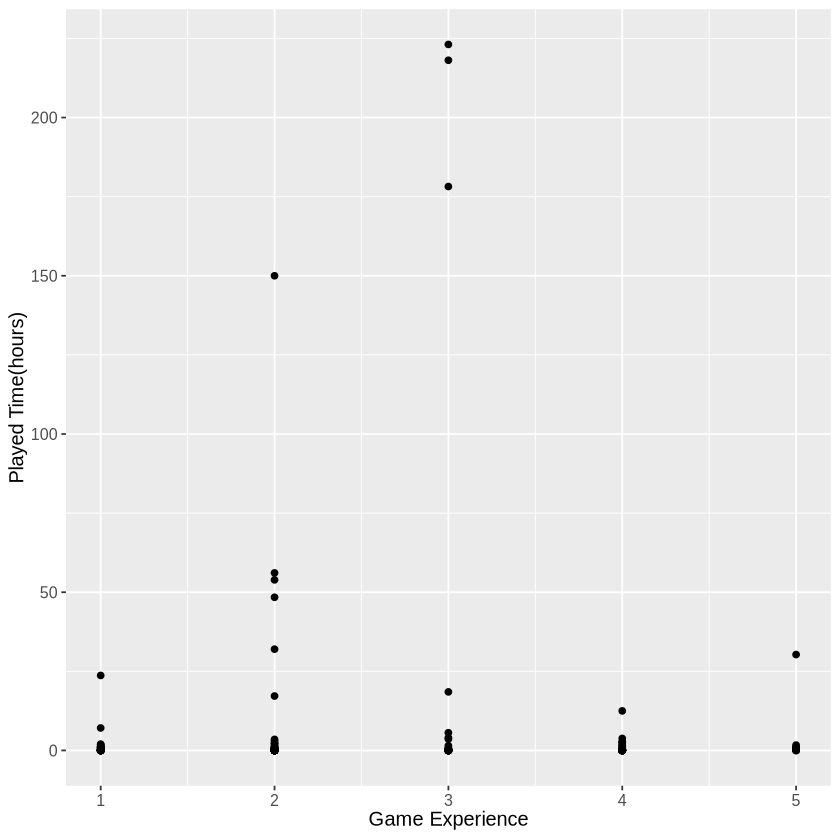

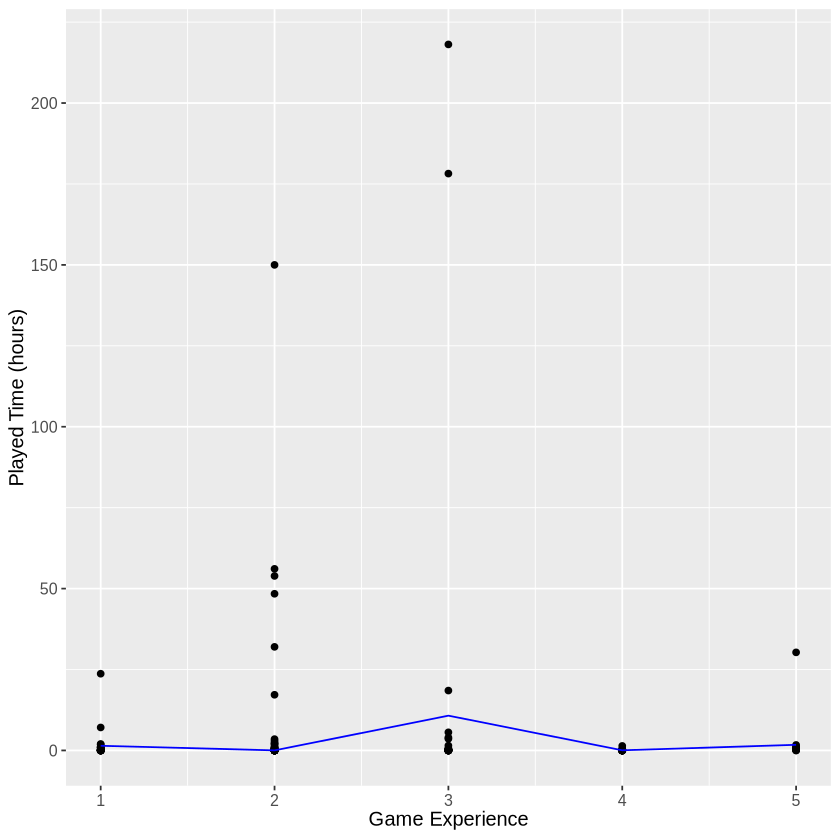

In [4]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
set.seed(2025)
experience <- read_csv("players.csv",  show_col_types = FALSE)
clean_experience <- experience |>
                    select(experience, played_hours) |>
                    tibble() |>
                    mutate(
    experience = factor(experience,
                        levels = c("Beginner", "Amateur", "Regular", "Veteran", "Pro"),
                        ordered = TRUE),
    experience_numeric = as.numeric(experience)
  )
clean_experience
graph_1 <- ggplot(clean_experience, aes(x = experience_numeric, y = played_hours)) +
           geom_point() +
           xlab("Game Experience") +
           ylab("Played Time(hours)") +
           theme(text = element_text(size = 12))
graph_1
experience_split <- initial_split(clean_experience, prop = 0.75, strata = played_hours)
experience_training <- training(experience_split)
experience_testing <- testing(experience_split)
experience_training
experience_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
       set_engine("kknn") |>
       set_mode("regression") 

experience_recipe <- recipe(played_hours ~ experience_numeric, data = experience_training) |>
       step_scale(all_predictors()) |>
       step_center(all_predictors())
experience_recipe
experience_vfold <- vfold_cv(experience_training, v = 5, strata = played_hours)
experience_workflow <- workflow() |>
  add_recipe(experience_recipe) |>
  add_model(experience_spec)
experience_workflow
gridvals <- tibble(neighbors = seq(from = 1, to = 80, by = 10))
experience_results <- experience_workflow |>
  tune_grid(resamples = experience_vfold, grid = gridvals) |>
  collect_metrics() 
experience_results
experience_min <- experience_results |>
    filter(.metric == "rmse") |>
    slice_min(mean, n = 1)
experience_min <- experience_min |>
          pull(neighbors)

experience_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = experience_min) |>
          set_engine("kknn") |>
          set_mode("regression")

experience_best_fit <- workflow() |>
          add_recipe(experience_recipe) |>
          add_model(experience_best_spec) |>
          fit(data = experience_training)

experience_summary <- experience_best_fit |>
           predict(experience_testing) |>
           bind_cols(experience_testing) |>
           metrics(truth = played_hours, estimate = .pred)
experience_summary
experience_preds <- bind_cols(experience_training, predict(experience_best_fit, experience_training))

experience_plot <- ggplot(experience_preds, aes(x = experience_numeric, y = played_hours)) +
  geom_point() +
  geom_line(aes(y = .pred), color = "blue") +
  xlab("Game Experience") +
  ylab("Played Time (hours)") +
  theme(text = element_text(size = 12))
experience_plot

The analysis began by selecting the relevant variables—experience and played_hours—and converting the experience variable into an ordered factor with five levels, from Beginner to Pro. A numeric version was also created to facilitate modelling. The dataset was split into a training set (75%) and a testing set (25%), using stratified sampling based on the response variable to maintain distributional balance. A preprocessing recipe was then applied to center and scale the predictor variable to ensure appropriate input for the KNN algorithm. I specified a KNN model with a rectangular weight function and defined the number of neighbors (k) as a tunable parameter. To optimize model performance, I used 5-fold cross-validation on the training data and tested values of k ranging from 1 to 80 in increments of 10. The final model was trained using the best-performing k and evaluated on the testing set. All steps, including preprocessing, model fitting, and evaluation, were organized using the workflow() structure to ensure consistency and reproducibility.
kNN regression was selected for this analysis because of its flexibility and non-parametric nature, which allows it to model complex relationships without requiring a predefined functional form. However, using KNN requires several considerations. First, it assumes that similar inputs yield similar outputs, which justifies using proximity in experience level as a basis for predicting playtime. Second, it relies on distance calculations, meaning that input features must be properly scaled—an assumption satisfied through preprocessing. Despite these advantages, KNN has limitations. It is sensitive to noise, outliers, and class imbalance. The model’s performance is also highly dependent on the choice of k; small values may lead to overfitting, while large values may oversmooth the predictions. Additionally, KNN can become computationally inefficient with larger datasets due to repeated distance calculations. To select the optimal k, I performed 5-fold cross-validation within the training set and chose the value that minimized the root mean squared error (RMSE). This strategy helps improve generalizability and avoids relying on a single train-test split. A final visualization was created to illustrate the fitted model's predictions relative to the training data, providing insight into the local trends captured by the model.

This analysis investigated whether a player’s total played hours could predict their experience level. The knn regression model showed a weak but noticeable upward trend—more experienced players generally had more playtime. However, large prediction errors and significant overlap in hours across experience levels indicate that playtime alone is not a strong or reliable predictor.
These results were partly expected. While it makes sense that experienced players play more, inconsistencies—such as beginners with high hours or pros with low ones—suggest that other factors, like skill acquisition rate, in-game behavior, and self-assessment, play important roles. The findings have practical implications. Relying solely on playtime to determine experience could lead to ineffective resource allocation in game systems. This highlights the need for more nuanced behavioral metrics in assessing player expertise. Future research could incorporate additional predictors like achievements, session frequency, or social interaction. Using models designed for ordinal outcomes—such as ordinal logistic regression—may also yield better results. Expanding the dataset or adding longitudinal data would further improve predictive accuracy and reveal trends over time.